In [81]:
pwd


'/Users/catalinagaitan/Documents/MBD/capstone_project/scripts'

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



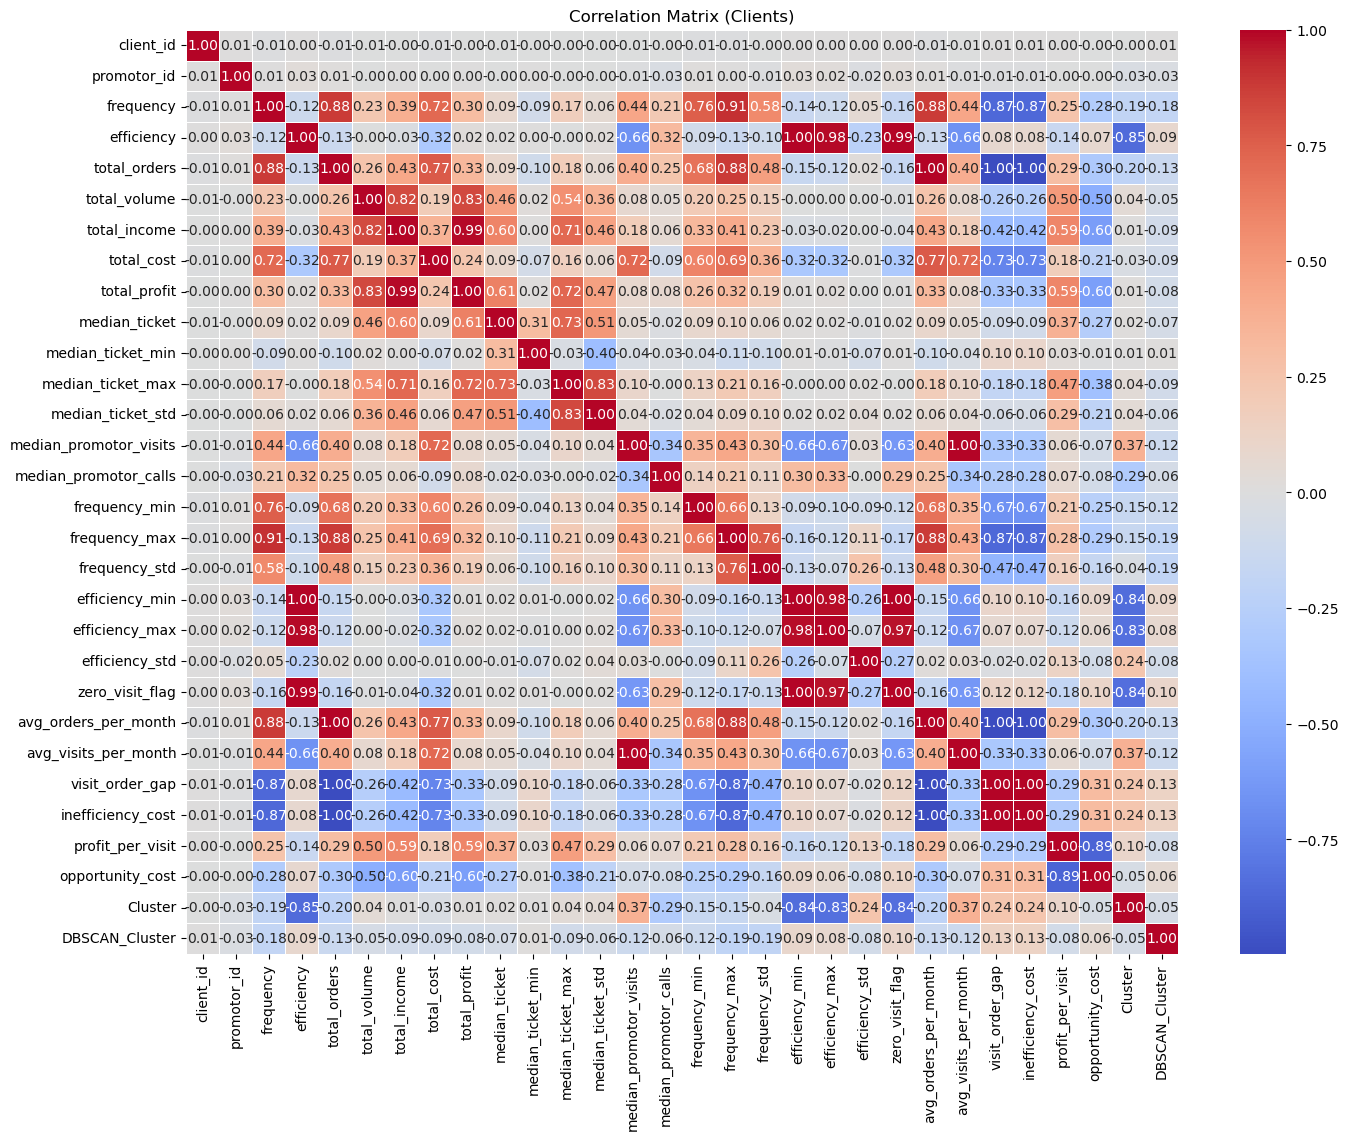

In [77]:
# Compute correlation matrix for the clients DataFrame (only numeric columns)
correlation_table = clients.corr(numeric_only=True)
correlation_table

import seaborn as sns

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_table, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Matrix (Clients)")
plt.show()

Load Data

In [10]:

clients = pd.read_csv('../data/processed/clients.csv')
orders = pd.read_csv('../data/processed/orders.csv')
orders_raw = pd.read_csv('../data/processed/orders_raw.csv')
clients_monthly = pd.read_csv('../data/processed/clients_monthly.csv')

In [5]:
print("clients.head():")
print(clients.head(), "\n")

print("orders.head():")
print(orders.head(), "\n")

print("orders_raw.head():")
print(orders_raw.head(), "\n")

print("clients_monthly.head():")
print(clients_monthly.head())

clients.head():
   client_id       city channel  promotor_id  frequency  efficiency  \
0  100006690     Madrid      AR    275609911        2.0        1.00   
1  100008050  Barcelona      AR    368568690        1.0       20.00   
2  100042162  Barcelona      HR    455263770        1.0        0.25   
3  100046227  Barcelona      AR    454554895        4.0        2.00   
4  100125158      Cadiz      HR    483340469        3.0        3.00   

   total_orders  total_volume  total_income  total_cost  ...  efficiency_max  \
0            22      1658.706       1494.53         880  ...             1.5   
1            14      3982.000       1905.59         140  ...            20.0   
2            14      1812.850       2243.30         980  ...             0.5   
3            16      4590.180       2273.12         640  ...             2.0   
4            25      1266.500       2204.24         625  ...             4.0   

   efficiency_std                   Class  zero_visit_flag  \
0        0.417

In [ ]:
clients_monthly.head()

,client_id,month,city,channel,promotor_id,total_orders,total_volume,total_income,total_cost,total_profit,median_ticket,median_ticket_min,median_ticket_max,median_ticket_std,median_promotor_visits,median_promotor_calls
0,100006690,1,Madrid,AR,275609911,2,202.500,203.99,80,123.99,101.995,80.10,123.89,30.964206,2.0,0.0
1,100006690,2,Madrid,AR,275609911,2,195.116,160.66,80,80.66,80.330,76.88,83.78,4.879037,2.0,0.0
2,100006690,3,Madrid,AR,275609911,2,138.528,111.39,80,31.39,55.695,33.00,78.39,32.095577,2.0,0.0
3,100006690,4,Madrid,AR,275609911,3,156.668,184.01,120,64.01,54.370,52.10,77.54,14.078325,2.0,0.0
4,100006690,5,Madrid,AR,275609911,3,175.288,172.16,120,52.16,59.780,51.42,60.96,5.200859,2.0,0.0


In [15]:
clients.info()
pd.set_option('display.max_columns', None)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41950 entries, 0 to 41949
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   client_id               41950 non-null  int64  
 1   city                    41950 non-null  object 
 2   channel                 41950 non-null  object 
 3   promotor_id             41950 non-null  int64  
 4   frequency               41950 non-null  float64
 5   efficiency              41950 non-null  float64
 6   total_orders            41950 non-null  int64  
 7   total_volume            41950 non-null  float64
 8   total_income            41950 non-null  float64
 9   total_cost              41950 non-null  int64  
 10  total_profit            41950 non-null  float64
 11  median_ticket           41950 non-null  float64
 12  median_ticket_min       41950 non-null  float64
 13  median_ticket_max       41950 non-null  float64
 14  median_ticket_std       39800 non-null

One-hot encode for City and Channel 

In [ ]:
categorical_cols = ['channel', 'city']
clients_encoded = pd.get_dummies(clients, columns=categorical_cols, drop_first=False)

# Drop the features that are not needed for clustering
non_features = [
    'client_id', 
    'Class', 'zero_visit_flag']
clients_encoded = clients_encoded.drop(columns=non_features)


In [76]:
clients_encoded

,promotor_id,frequency,efficiency,total_orders,total_volume,total_income,total_cost,total_profit,median_ticket,median_ticket_min,median_ticket_max,median_ticket_std,median_promotor_visits,median_promotor_calls,frequency_min,frequency_max,frequency_std,efficiency_min,efficiency_max,efficiency_std,avg_orders_per_month,avg_visits_per_month,visit_order_gap,inefficiency_cost,profit_per_visit,opportunity_cost,channel_AR,channel_HR,city_Alicante,city_Almeria,city_Asturias,city_Barcelona,city_Bilbao,city_Burgos,city_Cadiz,city_Castellon,city_Cordoba,city_Girona,city_Granada,city_Islas Baleares,city_Madrid,city_Malaga,city_Murcia,city_Pamplona,city_Santander,city_Sevilla,city_Tarragona,city_Valencia,city_Valladolid
0,275609911,2.0,1.00,22,1658.706,1494.53,880,614.53,60.990,33.00,123.89,22.262210,2.0,0.0,1,3,0.834847,0.50,1.5,0.417424,1.833333,0.166667,-1.666667,-25.00,307.265,-512.108333,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
1,368568690,1.0,20.00,14,3982.000,1905.59,140,1765.59,132.370,66.96,187.10,38.756311,0.0,2.0,1,2,0.516398,20.00,20.0,0.000000,1.166667,0.000000,-1.166667,-17.50,0.000,-0.000000,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,455263770,1.0,0.25,14,1812.850,2243.30,980,1263.30,128.125,29.62,220.82,49.543046,4.0,0.0,1,2,0.467099,0.25,0.5,0.116775,1.166667,0.333333,-0.833333,-12.50,315.825,-263.187500,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,454554895,4.0,2.00,16,4590.180,2273.12,640,1633.12,132.640,83.21,276.33,48.602430,2.0,2.0,4,4,0.000000,2.00,2.0,0.000000,1.333333,0.166667,-1.166667,-17.50,816.560,-952.653333,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,483340469,3.0,3.00,25,1266.500,2204.24,625,1579.24,85.810,26.15,173.95,41.511632,1.0,0.0,1,4,0.971825,1.00,4.0,0.971825,2.083333,0.083333,-2.000000,-30.00,1579.240,-3158.480000,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41945,480416490,2.0,2.00,23,691.000,785.30,575,210.30,38.330,25.55,55.23,9.544566,1.0,3.0,1,4,1.236033,1.00,4.0,1.236033,1.916667,0.083333,-1.833333,-27.50,210.300,-385.550000,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
41946,908993212,1.0,20.00,3,557.820,260.55,30,230.55,76.430,75.02,109.10,19.281958,0.0,0.0,1,1,0.000000,20.00,20.0,0.000000,0.250000,0.000000,-0.250000,-3.75,0.000,-0.000000,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
41947,275609911,1.0,0.50,13,1101.524,1044.61,520,524.61,68.260,50.03,183.56,36.563004,2.0,0.0,1,2,0.404520,0.50,1.0,0.202260,1.083333,0.166667,-0.916667,-13.75,262.305,-240.446250,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
41948,677360818,3.0,1.50,36,5415.150,3828.31,1410,2418.31,102.840,0.00,188.96,41.406391,2.0,2.0,2,4,0.738549,1.00,2.0,0.369274,3.000000,0.166667,-2.833333,-42.50,1209.155,-3425.939167,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [25]:
clients_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41950 entries, 0 to 41949
Data columns (total 49 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   promotor_id             41950 non-null  int64  
 1   frequency               41950 non-null  float64
 2   efficiency              41950 non-null  float64
 3   total_orders            41950 non-null  int64  
 4   total_volume            41950 non-null  float64
 5   total_income            41950 non-null  float64
 6   total_cost              41950 non-null  int64  
 7   total_profit            41950 non-null  float64
 8   median_ticket           41950 non-null  float64
 9   median_ticket_min       41950 non-null  float64
 10  median_ticket_max       41950 non-null  float64
 11  median_ticket_std       39800 non-null  float64
 12  median_promotor_visits  41950 non-null  float64
 13  median_promotor_calls   41950 non-null  float64
 14  frequency_min           41950 non-null

In [33]:
clients_encoded.isnull().sum().sort_values(ascending=False)


efficiency_std            2882
frequency_std             2882
median_ticket_std         2150
promotor_id                  0
city_Cordoba                 0
city_Alicante                0
city_Almeria                 0
city_Asturias                0
city_Barcelona               0
city_Bilbao                  0
city_Burgos                  0
city_Cadiz                   0
city_Castellon               0
city_Girona                  0
channel_AR                   0
city_Granada                 0
city_Islas Baleares          0
city_Madrid                  0
city_Malaga                  0
city_Murcia                  0
city_Pamplona                0
city_Santander               0
city_Sevilla                 0
city_Tarragona               0
city_Valencia                0
channel_HR                   0
profit_per_visit             0
opportunity_cost             0
frequency                    0
efficiency                   0
total_orders                 0
total_volume                 0
total_in

In [37]:
clients_encoded[['efficiency_std', 'frequency_std', 'median_ticket_std']].describe()


,efficiency_std,frequency_std,median_ticket_std
count,39068.000000,39068.000000,39800.000000
mean,0.363168,0.725654,62.220006
std,0.724164,0.450565,200.417043
min,0.000000,0.000000,0.000000
25%,0.000000,0.500000,18.936818
50%,0.257464,0.699206,34.475993
75%,0.471940,0.965307,62.516596
max,13.965359,5.656854,20543.482115


In [ ]:
# Impute missing values - PLEASE REVIEW WHETHER THIS IS APPROPRIATE FOR THE DATA as i chose avg. not sure if it impacts the clustering
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
features_imputed = pd.DataFrame(imputer.fit_transform(clients_encoded), columns=clients_encoded.columns)

# Standard scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_imputed)

In [38]:
# KMeans clustering - elbow method and silhouette score
K_range = range(2, 11)
inertia_values = []
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertia_values.append(kmeans.inertia_)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)


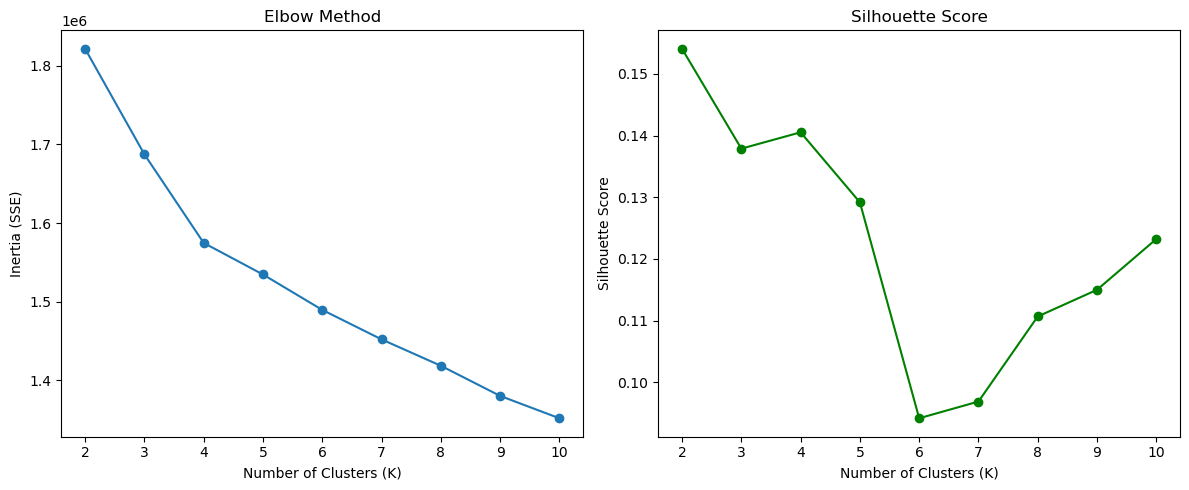

In [42]:
# Plotting the results

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K_range, inertia_values, 'o-')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (SSE)')

plt.subplot(1,2,2)
plt.plot(K_range, silhouette_scores, 'o-', color='green')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()


Fit Final model

Unique clusters assigned: 4


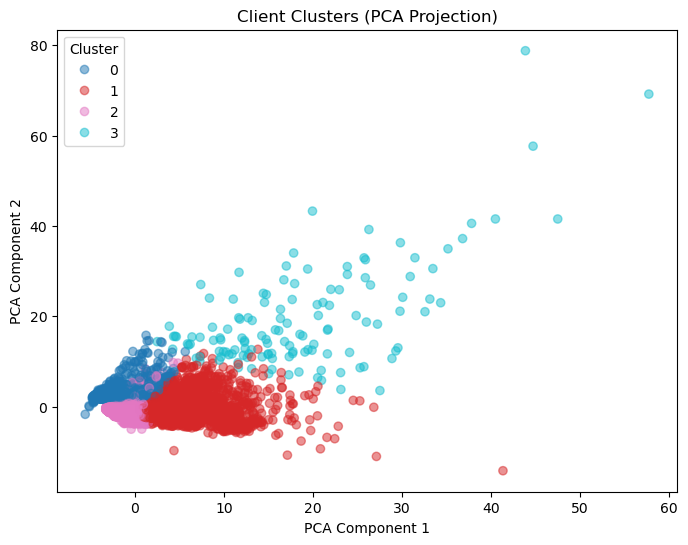

,client_id,promotor_id,frequency,efficiency,total_orders,total_volume,total_income,total_cost,total_profit,median_ticket,median_ticket_min,median_ticket_max,median_ticket_std,median_promotor_visits,median_promotor_calls,frequency_min,frequency_max,frequency_std,efficiency_min,efficiency_max,efficiency_std,zero_visit_flag,avg_orders_per_month,avg_visits_per_month,visit_order_gap,inefficiency_cost,profit_per_visit,opportunity_cost
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5.515707e+08,5.130251e+08,1.929844,20.000000,16.913958,2548.252032,2197.368409,169.139583,2028.228826,121.527921,54.100276,225.750474,54.827548,0.000000,1.473437,1.296458,2.769896,0.601593,20.000000,20.000000,0.000000,1.000000,1.409497,0.000000,-1.409497,-21.142448,0.000000,0.000000
1,5.479712e+08,4.994949e+08,4.086865,2.086403,46.426757,6963.822744,7758.015942,2593.248402,5164.767540,146.944224,21.999403,354.690469,70.343933,2.971998,0.961487,2.449378,5.494366,0.962454,1.378554,2.745406,0.432615,0.016818,3.868896,0.247666,-3.621230,-54.318449,2132.257204,-8308.367920
2,5.504894e+08,4.897347e+08,1.708698,1.131121,13.534783,1976.265400,1526.796997,514.818459,1011.978538,106.281005,53.873771,198.486376,48.500987,1.861015,0.501993,1.166683,2.603365,0.624807,0.781005,1.883399,0.489153,0.000098,1.127899,0.155085,-0.972814,-14.592209,696.643526,-990.012732
3,5.249769e+08,5.027287e+08,5.613636,7.712121,67.106061,208900.953864,133831.296364,3742.310606,130088.985758,2050.636199,-104.411288,6818.029773,1791.010110,2.515152,1.212121,3.416667,8.522727,1.618303,7.012311,8.756629,0.564034,0.303030,5.592172,0.209596,-5.382576,-80.738636,30380.404782,-167776.541985


In [60]:
# Fit Final model
# Based on the elbow method and silhouette score, we choose an optimal number of clusters to be 4 

optimal_k = 4
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
final_labels = final_kmeans.fit_predict(X_scaled)

# Add labels to clients dataframe
clients['Cluster'] = final_labels

# Verify
print("Unique clusters assigned:", clients['Cluster'].nunique())

from sklearn.decomposition import PCA

# Visualize clusters using the first two principal components

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clients['Cluster'], cmap='tab10', alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Client Clusters (PCA Projection)')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

# Analyze cluster profiles
cluster_profiles = clients.groupby('Cluster').mean(numeric_only=True)
display(cluster_profiles)

# Save results
clients.to_csv('clients_clusters.csv', index=False)

In [64]:
cluster_counts = clients['Cluster'].value_counts().sort_index()
cluster_percent = cluster_counts / len(clients) * 100

for cluster_id, count in cluster_counts.items():
    percent = cluster_percent[cluster_id]
    print(f"Cluster {cluster_id}: {count} rows ({percent:.2f}%)")

Cluster 0: 9600 rows (22.88%)
Cluster 1: 11892 rows (28.35%)
Cluster 2: 20326 rows (48.45%)
Cluster 3: 132 rows (0.31%)


In [ ]:


clients['Cluster'] = final_labels
clients.head()

,client_id,city,channel,promotor_id,frequency,efficiency,total_orders,total_volume,total_income,total_cost,total_profit,median_ticket,median_ticket_min,median_ticket_max,median_ticket_std,median_promotor_visits,median_promotor_calls,frequency_min,frequency_max,frequency_std,efficiency_min,efficiency_max,efficiency_std,Class,zero_visit_flag,avg_orders_per_month,avg_visits_per_month,visit_order_gap,inefficiency_cost,profit_per_visit,opportunity_cost,Cluster
0,100006690,Madrid,AR,275609911,2.0,1.00,22,1658.706,1494.53,880,614.53,60.990,33.00,123.89,22.262210,2.0,0.0,1,3,0.834847,0.50,1.5,0.417424,LowTicket_Inefficient,False,1.833333,0.166667,-1.666667,-25.0,307.265,-512.108333,2
1,100008050,Barcelona,AR,368568690,1.0,20.00,14,3982.000,1905.59,140,1765.59,132.370,66.96,187.10,38.756311,0.0,2.0,1,2,0.516398,20.00,20.0,0.000000,HighTicket_Efficient,True,1.166667,0.000000,-1.166667,-17.5,0.000,-0.000000,0
2,100042162,Barcelona,HR,455263770,1.0,0.25,14,1812.850,2243.30,980,1263.30,128.125,29.62,220.82,49.543046,4.0,0.0,1,2,0.467099,0.25,0.5,0.116775,HighTicket_Inefficient,False,1.166667,0.333333,-0.833333,-12.5,315.825,-263.187500,2
3,100046227,Barcelona,AR,454554895,4.0,2.00,16,4590.180,2273.12,640,1633.12,132.640,83.21,276.33,48.602430,2.0,2.0,4,4,0.000000,2.00,2.0,0.000000,HighTicket_Efficient,False,1.333333,0.166667,-1.166667,-17.5,816.560,-952.653333,2
4,100125158,Cadiz,HR,483340469,3.0,3.00,25,1266.500,2204.24,625,1579.24,85.810,26.15,173.95,41.511632,1.0,0.0,1,4,0.971825,1.00,4.0,0.971825,HighTicket_Efficient,False,2.083333,0.083333,-2.000000,-30.0,1579.240,-3158.480000,2


In [58]:
cluster_profiles = clients.groupby('Cluster').mean(numeric_only=True)
cluster_profiles

,client_id,promotor_id,frequency,efficiency,total_orders,total_volume,total_income,total_cost,total_profit,median_ticket,median_ticket_min,median_ticket_max,median_ticket_std,median_promotor_visits,median_promotor_calls,frequency_min,frequency_max,frequency_std,efficiency_min,efficiency_max,efficiency_std,zero_visit_flag,avg_orders_per_month,avg_visits_per_month,visit_order_gap,inefficiency_cost,profit_per_visit,opportunity_cost
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5.515707e+08,5.130251e+08,1.929844,20.000000,16.913958,2548.252032,2197.368409,169.139583,2028.228826,121.527921,54.100276,225.750474,54.827548,0.000000,1.473437,1.296458,2.769896,0.601593,20.000000,20.000000,0.000000,1.000000,1.409497,0.000000,-1.409497,-21.142448,0.000000,0.000000
1,5.479712e+08,4.994949e+08,4.086865,2.086403,46.426757,6963.822744,7758.015942,2593.248402,5164.767540,146.944224,21.999403,354.690469,70.343933,2.971998,0.961487,2.449378,5.494366,0.962454,1.378554,2.745406,0.432615,0.016818,3.868896,0.247666,-3.621230,-54.318449,2132.257204,-8308.367920
2,5.504894e+08,4.897347e+08,1.708698,1.131121,13.534783,1976.265400,1526.796997,514.818459,1011.978538,106.281005,53.873771,198.486376,48.500987,1.861015,0.501993,1.166683,2.603365,0.624807,0.781005,1.883399,0.489153,0.000098,1.127899,0.155085,-0.972814,-14.592209,696.643526,-990.012732
3,5.249769e+08,5.027287e+08,5.613636,7.712121,67.106061,208900.953864,133831.296364,3742.310606,130088.985758,2050.636199,-104.411288,6818.029773,1791.010110,2.515152,1.212121,3.416667,8.522727,1.618303,7.012311,8.756629,0.564034,0.303030,5.592172,0.209596,-5.382576,-80.738636,30380.404782,-167776.541985


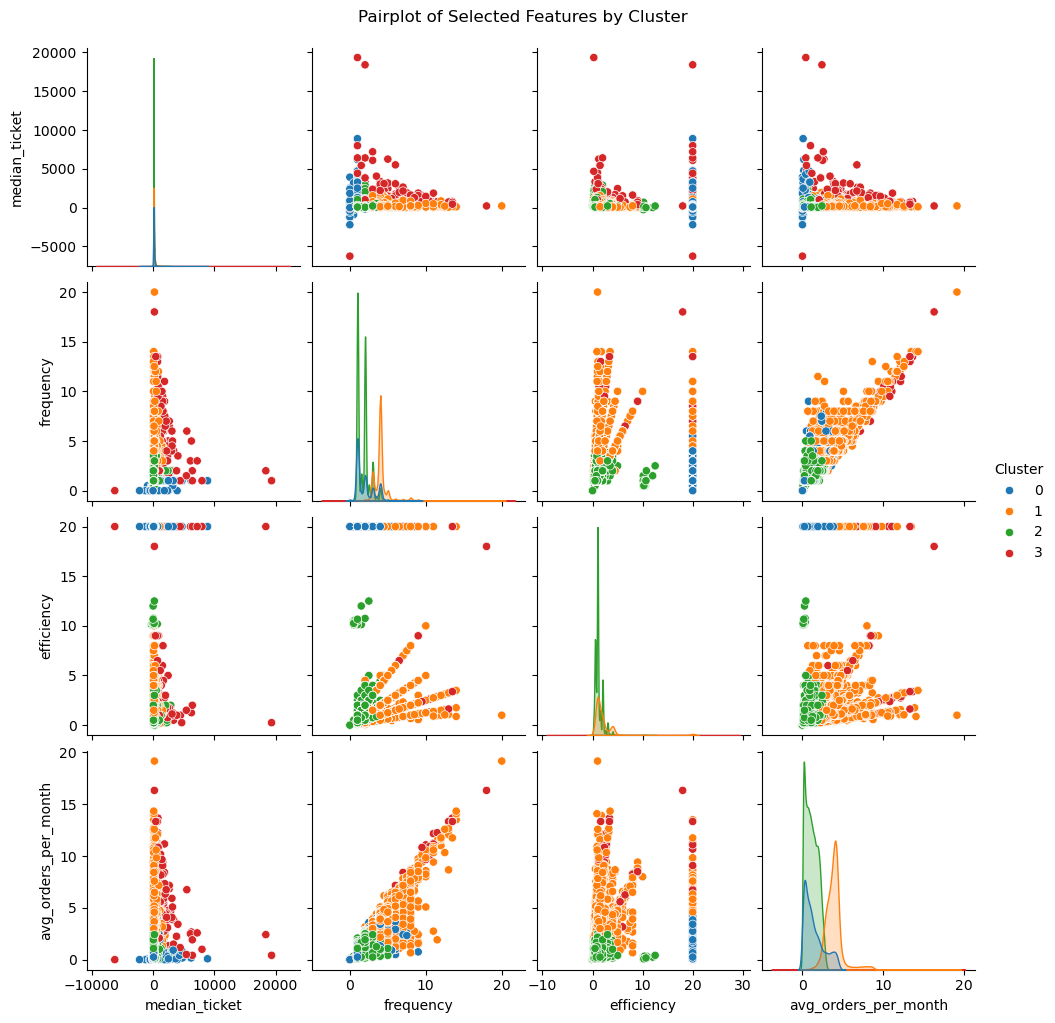

In [67]:
selected_cols = ['median_ticket', 'frequency', 'efficiency', 'avg_orders_per_month', 'Cluster', 'Class']
sns.pairplot(clients[selected_cols], hue='Cluster', palette='tab10')
plt.suptitle('Pairplot of Selected Features by Cluster', y=1.02)
plt.show()


/var/folders/f9/gm4h0_wx2gn_4gjm2dmvcyk40000gn/T/ipykernel_89980/384098082.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clients, x='Cluster', y=col, palette='tab10')


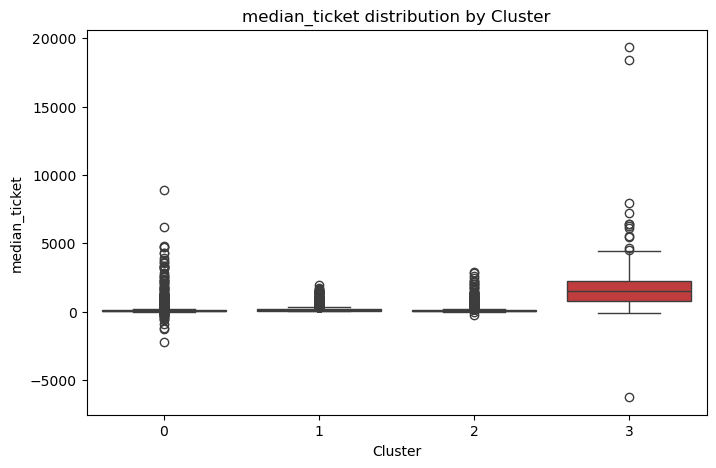

/var/folders/f9/gm4h0_wx2gn_4gjm2dmvcyk40000gn/T/ipykernel_89980/384098082.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clients, x='Cluster', y=col, palette='tab10')


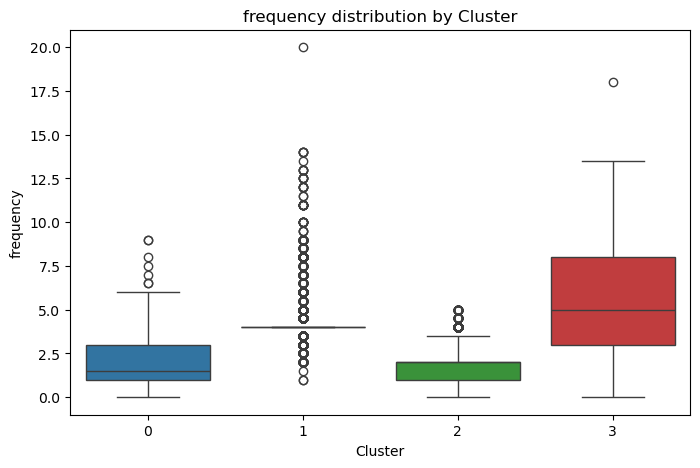

/var/folders/f9/gm4h0_wx2gn_4gjm2dmvcyk40000gn/T/ipykernel_89980/384098082.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clients, x='Cluster', y=col, palette='tab10')


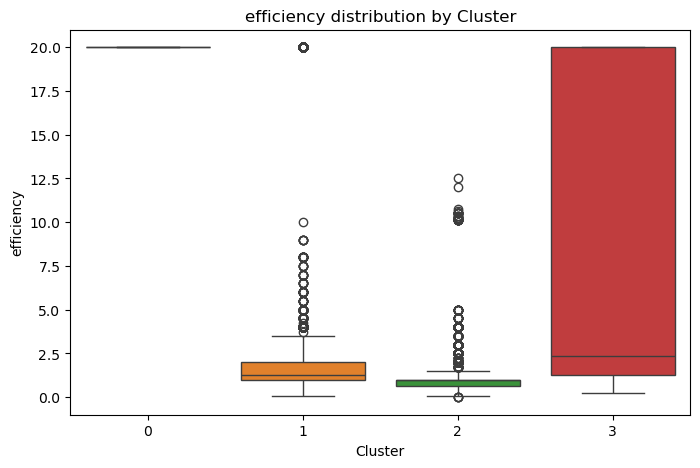

/var/folders/f9/gm4h0_wx2gn_4gjm2dmvcyk40000gn/T/ipykernel_89980/384098082.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clients, x='Cluster', y=col, palette='tab10')


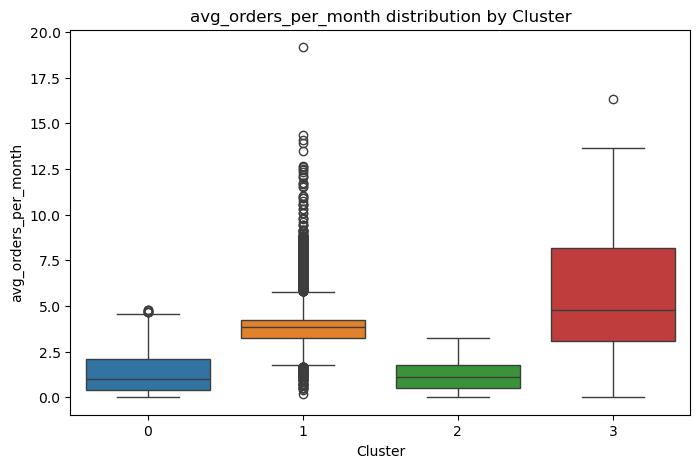

/var/folders/f9/gm4h0_wx2gn_4gjm2dmvcyk40000gn/T/ipykernel_89980/384098082.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clients, x='Cluster', y=col, palette='tab10')


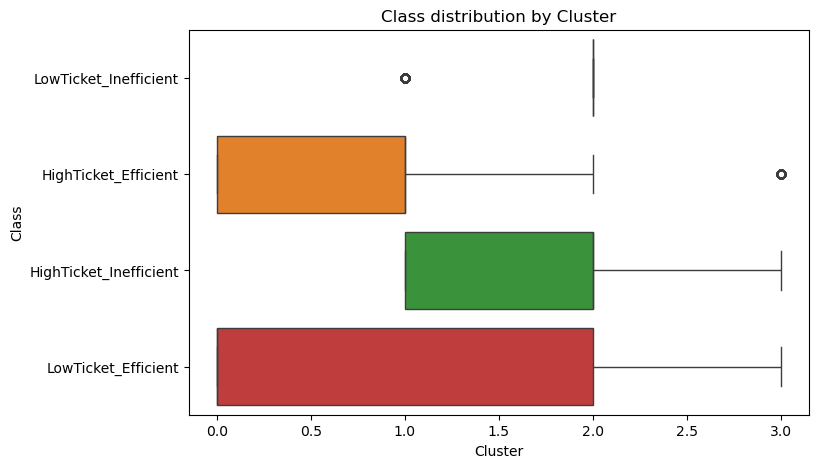

In [72]:
features_to_plot = ['median_ticket', 'frequency', 'efficiency', 'avg_orders_per_month','Class']

for col in features_to_plot:
    plt.figure(figsize=(8,5))
    sns.boxplot(data=clients, x='Cluster', y=col, palette='tab10')
    plt.title(f'{col} distribution by Cluster')
    plt.show()


In [73]:
cluster_counts = clients['Cluster'].value_counts().sort_index()
cluster_percent = (cluster_counts / len(clients) * 100).round(2)

cluster_summary = pd.DataFrame({
    'Count': cluster_counts,
    'Percent': cluster_percent
})

display(cluster_summary)

,Count,Percent
Cluster,,
0,9600,22.88
1,11892,28.35
2,20326,48.45
3,132,0.31


In [74]:
# Aggregate number of rows in clients by Class type
class_counts = clients.groupby('Class').size()

# Calculate % of rows of each cluster within each Class
cluster_class_counts = clients.groupby(['Class', 'Cluster']).size().unstack(fill_value=0)
cluster_class_percent = cluster_class_counts.div(cluster_class_counts.sum(axis=1), axis=0) * 100

# Display results
print("Number of clients by Class:")
display(class_counts)

print("\nCluster distribution (%) within each Class:")
display(cluster_class_percent.round(2))

Number of clients by Class:


Class
HighTicket_Efficient      11385
HighTicket_Inefficient    12028
LowTicket_Efficient       10103
LowTicket_Inefficient      8434
dtype: int64


Cluster distribution (%) within each Class:


Cluster,0,1,2,3
Class,,,,
HighTicket_Efficient,38.89,40.41,19.73,0.97
HighTicket_Inefficient,0.00,32.77,67.07,0.16
LowTicket_Efficient,51.19,20.75,28.03,0.03
LowTicket_Inefficient,0.00,14.86,85.14,0.00


In [75]:
# Describe statistics for each cluster in the clients DataFrame
cluster_stats = clients.groupby('Cluster').describe().T
display(cluster_stats)

Cluster                          0             1             2             3
client_id      count  9.600000e+03  1.189200e+04  2.032600e+04  1.320000e+02
               mean   5.515707e+08  5.479712e+08  5.504894e+08  5.249769e+08
               std    2.603949e+08  2.608669e+08  2.597959e+08  2.743032e+08
               min    1.000080e+08  1.001758e+08  1.000067e+08  1.084703e+08
               25%    3.278014e+08  3.223886e+08  3.256922e+08  2.848695e+08
...                            ...           ...           ...           ...
DBSCAN_Cluster min   -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00
               25%   -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00
               50%   -1.000000e+00 -1.000000e+00  0.000000e+00 -1.000000e+00
               75%    9.000000e+00  2.000000e+00  4.000000e+00 -1.000000e+00
               max    4.600000e+01  4.700000e+01  4.300000e+01 -1.000000e+00

[224 rows x 4 columns]

DBSCAN Analysis

Estimated number of clusters (excluding noise): 48
Number of noise points: 21360


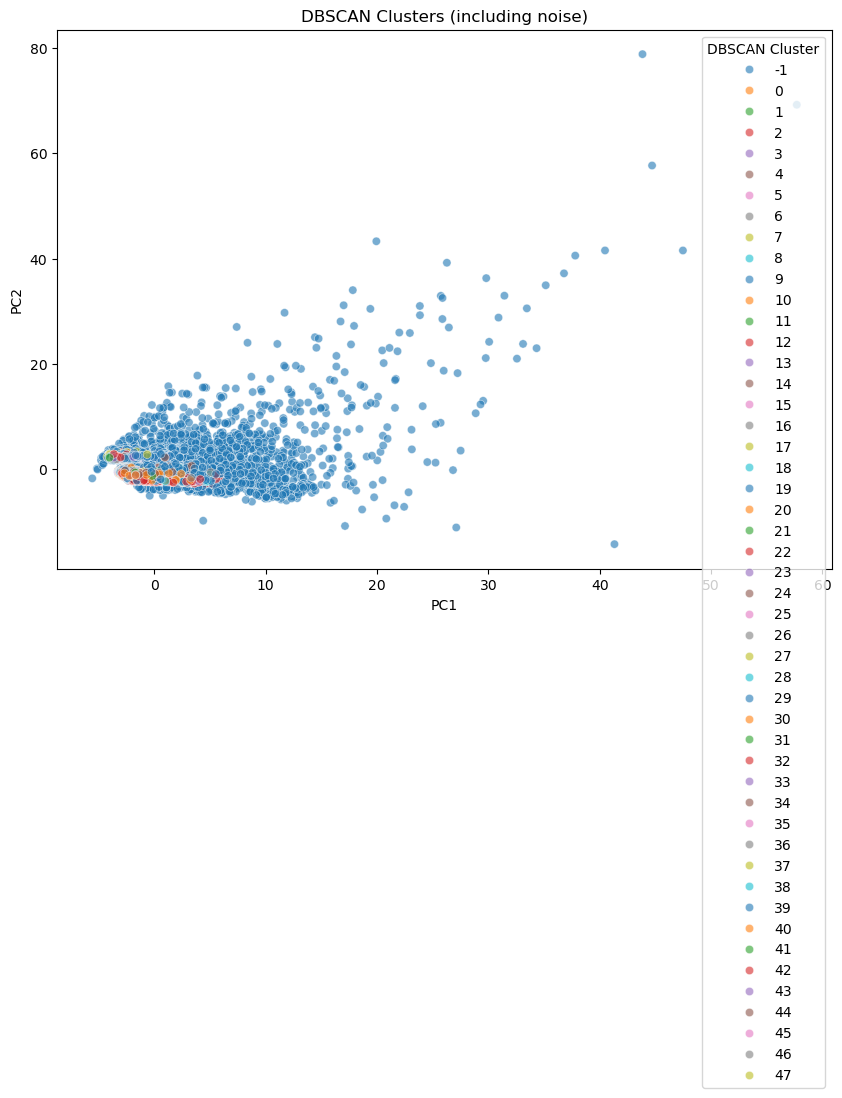

DBSCAN_Cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
client_id,5.505175e+08,5.567965e+08,5.521000e+08,5.441986e+08,5.510618e+08,5.517802e+08,5.273405e+08,5.622424e+08,5.566860e+08,5.664223e+08,5.446782e+08,5.378593e+08,5.494773e+08,5.612687e+08,5.482494e+08,5.681035e+08,5.610854e+08,5.141164e+08,5.736094e+08,5.733335e+08,5.511058e+08,5.258231e+08,5.513975e+08,5.784743e+08,5.624069e+08,6.081415e+08,5.818354e+08,5.659284e+08,4.991355e+08,5.528115e+08,5.398483e+08,4.827030e+08,5.551365e+08,5.557632e+08,5.082705e+08,5.887921e+08,5.642964e+08,5.578790e+08,6.081851e+08,5.529094e+08,5.351108e+08,5.211310e+08,5.659402e+08,5.100071e+08,5.455509e+08,5.373129e+08,5.059425e+08,5.430319e+08
promotor_id,4.781113e+08,4.704836e+08,5.609927e+08,5.735457e+08,5.222231e+08,3.125613e+08,6.232387e+08,3.131246e+08,5.832421e+08,5.377377e+08,5.508133e+08,5.279007e+08,9.750082e+08,4.309302e+08,5.511049e+08,9.695212e+08,5.889257e+08,8.664529e+08,3.155521e+08,3.140842e+08,7.770873e+08,1.671721e+07,2.870032e+08,1.235813e+08,3.074827e+08,4.441091e+08,5.821112e+08,4.245902e+08,6.032245e+08,2.219852e+08,7.020392e+08,5.498835e+08,5.752660e+08,3.137736e+08,4.465719e+08,4.492545e+08,4.166397e+08,5.848593e+08,3.333686e+08,6.844784e+08,3.019942e+08,4.391988e+08,5.058952e+08,3.512691e+08,7.169838e+08,4.801425e+08,9.498775e+08,1.777620e+08
frequency,1.567639e+00,1.243182e+00,2.445194e+00,1.538717e+00,1.989164e+00,1.410603e+00,1.339901e+00,1.374684e+00,3.375465e+00,1.311973e+00,1.320557e+00,1.463855e+00,1.307910e+00,3.026005e+00,1.422348e+00,1.376923e+00,3.903766e+00,1.102804e+00,1.292339e+00,1.286561e+00,1.506289e+00,1.329897e+00,1.312775e+00,3.992481e+00,1.301003e+00,4.024096e+00,1.605634e+00,1.363309e+00,1.352941e+00,3.906863e+00,3.231293e+00,1.368852e+00,4.025000e+00,1.162162e+00,3.957627e+00,1.253589e+00,1.423077e+00,1.438017e+00,3.706522e+00,1.440678e+00,1.096591e+00,1.128049e+00,1.067073e+00,1.072917e+00,3.850000e+00,3.931507e+00,1.153846e+00,3.880435e+00
efficiency,9.107974e-01,2.000000e+01,1.092416e+00,1.179019e+00,1.166638e+00,1.244802e+00,2.000000e+01,2.000000e+01,8.447955e-01,2.000000e+01,9.904181e-01,1.163655e+00,2.000000e+01,2.000000e+01,1.003788e+00,2.000000e+01,9.759414e-01,2.000000e+01,2.000000e+01,1.093874e+00,9.669811e-01,9.896907e-01,2.000000e+01,1.028195e+00,1.197324e+00,1.006024e+00,1.193662e+00,1.057554e+00,1.217647e+00,9.767157e-01,8.095238e-01,1.233607e+00,1.006250e+00,2.000000e+01,9.894068e-01,2.000000e+01,1.210526e+00,1.359504e+00,3.706522e+00,2.000000e+01,9.886364e-01,9.329268e-01,2.000000e+01,9.505208e-01,2.000000e+01,1.965753e+00,2.000000e+01,9.701087e-01
total_orders,1.552156e+01,9.363636e+00,2.304869e+01,1.419358e+01,1.992076e+01,1.070686e+01,9.715517e+00,1.194937e+01,3.753160e+01,1.098482e+01,9.602787e+00,1.384739e+01,1.147458e+01,3.338771e+01,1.267803e+01,1.111538e+01,4.682427e+01,7.757009e+00,9.314516e+00,9.474308e+00,1.605031e+01,9.752577e+00,1.208370e+01,4.734586e+01,1.199666e+01,4.914458e+01,1.541549e+01,1.210791e+01,1.357647e+01,4.560784e+01,3.813605e+01,1.262295e+01,4.883333e+01,6.929730e+00,4.647458e+01,9.468900e+00,1.288259e+01,1.146281e+01,4.271739e+01,1.367797e+01,7.227273e+00,7.841463e+00,6.682927e+00,6.802083e+00,4.488000e+01,4.573973e+01,5.738462e+00,4.654348e+01
total_volume,2.242251e+03,1.808245e+03,1.620970e+03,1.158183e+03,5.099243e+03,1.287556e+03,9.049397e+02,3.000351e+03,3.387474e+03,8.302575e+02,4.568300e+02,5.477954e+02,3.198234e+03,2.254798e+03,3.094125e+03,9.544440e+02,1.427800e+04,1.217234e+03,1.135834e+03,2.167210e+03,2.964371e+03,6.867801e+02,3.232572e+03,2.964893e+03,3.334925e+03,3.739094e+03,7.776611e+02,5.605659e+02,8.841279e+02,2.994284e+03,4.904172e+03,8.759686e+02,5.425854e+03,6.493554e+02,3.337396e+03,4.564416e+02,5.589829e+02,5.477380e+02,3.997179e+03,7.460104e+02,2.403304e+03,3.626736e+02,5.997877e+02,6.651009e+02,3.548672e+03,2.486781e+03,4.131785e+02,6.218096e+03
total_income,1.714688e+03,8.827113e+02

In [69]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Fit DBSCAN
dbscan_model = DBSCAN(eps=1.5, min_samples=50)
dbscan_labels = dbscan_model.fit_predict(X_scaled)
clients['DBSCAN_Cluster'] = dbscan_labels

# 2. Count clusters and noise
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
print(f"Estimated number of clusters (excluding noise): {n_clusters}")
print(f"Number of noise points: {n_noise}")

# 3. PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['DBSCAN_Cluster'] = clients['DBSCAN_Cluster']

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=pca_df,
    x='PC1', y='PC2',
    hue='DBSCAN_Cluster',
    palette='tab10',
    alpha=0.6
)
plt.title('DBSCAN Clusters (including noise)')
plt.legend(title='DBSCAN Cluster')
plt.show()

# 4. Analyze cluster profiles
dbscan_profiles = clients[clients['DBSCAN_Cluster'] != -1].groupby('DBSCAN_Cluster').mean(numeric_only=True)
display(dbscan_profiles.T)

# 5. Optional: Export
clients.to_csv('clients_with_dbscan_labels.csv', index=False)


In [78]:
# Select columns related to efficiency and ticket features
efficiency_features = [col for col in features_imputed.columns if 'efficiency' in col]
ticket_features = [col for col in features_imputed.columns if 'ticket' in col]

# Combine the lists and create the new DataFrame
efficiency_ticket_df = features_imputed[efficiency_features + ticket_features]
efficiency_ticket_df.head()

,efficiency,efficiency_min,efficiency_max,efficiency_std,inefficiency_cost,median_ticket,median_ticket_min,median_ticket_max,median_ticket_std
0,1.00,0.50,1.5,0.417424,-25.0,60.990,33.00,123.89,22.262210
1,20.00,20.00,20.0,0.000000,-17.5,132.370,66.96,187.10,38.756311
2,0.25,0.25,0.5,0.116775,-12.5,128.125,29.62,220.82,49.543046
3,2.00,2.00,2.0,0.000000,-17.5,132.640,83.21,276.33,48.602430
4,3.00,1.00,4.0,0.971825,-30.0,85.810,26.15,173.95,41.511632


In [80]:
# Impute missing values - PLEASE REVIEW WHETHER THIS IS APPROPRIATE FOR THE DATA as i chose avg. not sure if it impacts the clustering
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
features_imputed = pd.DataFrame(imputer.fit_transform(clients_encoded), columns=clients_encoded.columns)

# Standard scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(efficiency_ticket_df)